In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf


In [105]:
#*** Funções auxiliares para ler imagens do disco e plotar resultados
def readImagesFromDir(imgDirPath):
    fileNames = os.listdir(imgDirPath)
    imagePaths = [os.path.join(imgDirPath,img) for img in fileNames if img[-3:] in ['jpg', 'png']]
    imageList = [load_img(img, target_size=(224, 224)) for img in imagePaths]
    imageList = [img_to_array(img) for img in imageList]
    return imageList, fileNames

# plota as imagens de imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='BICUBIC')
    plt.show()

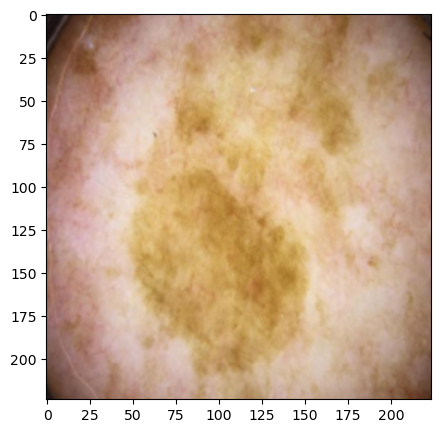

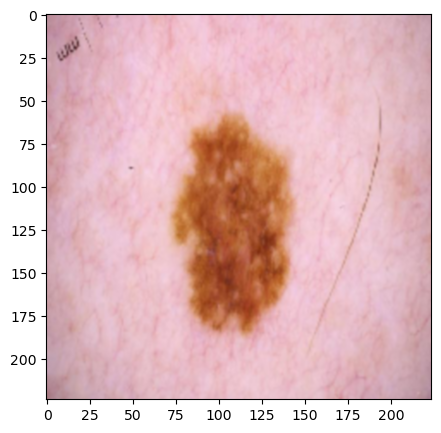

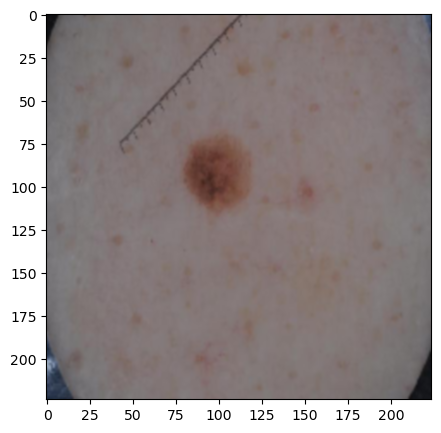

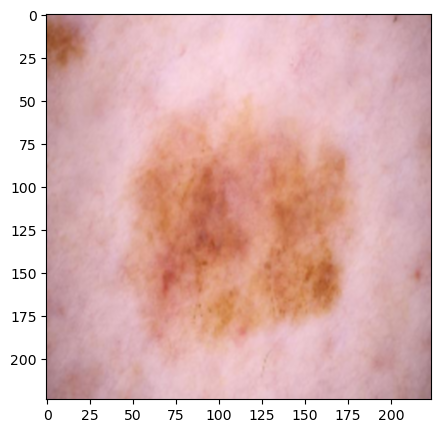

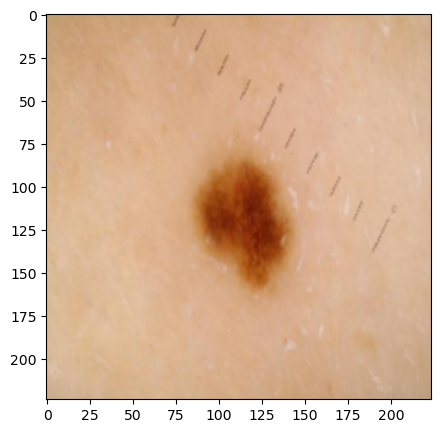

In [110]:
# Carrega e plota as imagens
imgList, fileNames = readImagesFromDir('../data/interim/treino/maligno/')
plotImages(imgList[0:4])

Exemplos de parâmetros para data augmentation:
*  rotation_range: faixa de graus para rotações aleatórias;
*  width_shift_range e height_shift_range: fração da largura e algura total;
*  shear_range: ângulo de cisalhamento no sentido anti-horário em graus;
*  zoom_range: intervalo para zoom aleatório;
*  horizontal_flip: inverte aleatoriamente as entradas horizontalmente; e
*  fill_mode: tipo de preenchimento que será realizado fora dos limites de entrada.

Found 24399 images belonging to 2 classes.


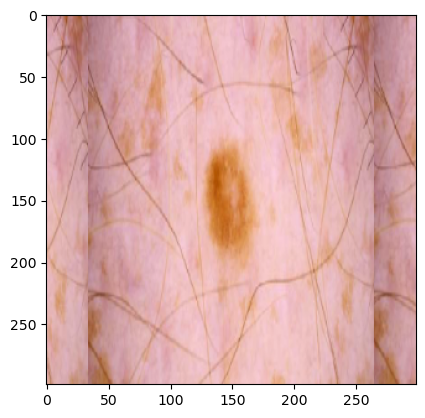

In [119]:
# visualizando as transformações que o augmentation faz nas imagens nas imagens

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        zoom_range=0.8,
        fill_mode='wrap') # options avaiable: constant, reflect, wrap, nearest

train_generator = train_datagen.flow_from_directory(
        '../data/interim/treino/',
        target_size=(299, 299),
        batch_size=256,
        class_mode='categorical')

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255),  # Normaliza os valores dos pixels para o intervalo [0, 1]
    tf.keras.layers.Input(shape=(299, 299, 3)),  # Define a entrada do modelo com tamanho (299, 299, 3)
    # Adicione mais camadas conforme necessário para a construção do seu modelo
])


for i in range(1):
    image = train_generator[0][0][0].astype('uint8')
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
    plt.show()

In [125]:
# Aplicando o augentation definino em todas as imagens do treino

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'  # options avaiable: constant, reflect, wrap, nearest
)

train_generator = train_datagen.flow_from_directory(
    '../data/interim/treino/',
    target_size=(299, 299),
    batch_size=256,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
        '../data/interim/validacao/',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)


Found 24399 images belonging to 2 classes.


In [126]:
model_base = tf.keras.applications.ResNet50(include_top=True, weights="imagenet")
model_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_17[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [127]:
# Selecionando a última camada desajada

model = tf.keras.models.Model(inputs = model_base.input, 
              outputs = model_base.get_layer('avg_pool').output)

In [130]:
train_dir = '../data/interim/treino/'
val_dir = '../data/interim/validacao/'

batch_size=256

def extract_features(directory, sample_count):
    # Calcula o número de lotes necessários
    num_batches = (sample_count + batch_size - 1) // batch_size

    # Cria matrizes vazias para armazenar as características e os rótulos
    features = np.zeros(shape=(num_batches * batch_size, 2048))
    labels = np.zeros(shape=(num_batches * batch_size, 2))

    generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical'
    )

    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)

        # Calcula o índice final do lote
        end_index = i * batch_size + len(inputs_batch)

        # Armazena as características e rótulos no local apropriado nas matrizes
        features[i * batch_size:end_index] = features_batch
        labels[i * batch_size:end_index] = labels_batch

        i += 1
        if i >= num_batches:
            break

    return features[:sample_count], labels[:sample_count]

# Exemplo de uso da função extract_features
train_features, train_labels = extract_features(train_dir, 33125)

Found 24399 images belonging to 2 classes.
8/8 [==============================] - 7s 825ms/step


In [ ]:
frozen_model = tf.keras.Sequential([
  model_base,
  tf.keras.layers.Reshape((-1, 1, 1000)),  # Reshape to a 4-dimensional tensor
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(2, activation='sigmoid')
])

frozen_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 reshape (Reshape)           (None, 1, 1, 1000)        0         
                                                                 
 global_average_pooling2d_2   (None, 1000)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25,638,714
Trainable params: 25,585,594
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
sgd = tf.keras.optimizers.legacy.SGD(learning_rate=0.01, momentum=0.9, decay=0.01, nesterov=True)

In [ ]:
frozen_model.compile(optimizer='sgd',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['auc'])

              

In [ ]:
# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

frozen_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['AUC'])

frozen_model.fit(train_generator, epochs=25, callbacks=[early], class_weight=train_class_weights, validation_data=validation_generator)

Epoch 1/25
 262/1036 [======>.......................] - ETA: 1:26:26 - loss: 7014.1802 - auc: 0.9839

KeyboardInterrupt: 

In [ ]:
# full_model será o seu modelo 
preds = frozen_model.predict(train_generator)                                           ;ç
preds = np.argmax(preds, axis=1)

batch_index = 0
data_list = []
while batch_index <= train_generator.batch_index:
    _, label = train_generator.next()
    data_list.extend(label)
    batch_index = batch_index + 1

gt = np.argmax(data_list, axis=1)
auc = roc_auc_score(gt, preds)
print("auc :", auc)/////                                                                                                                                                                                                                                           